In [22]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score 

In [24]:
df_final = pd.read_csv("df_final.csv")

In [25]:
cat_cols = ['os', 'browser','slot_id', "ssp_uid",'carrier_name', 'region','creative_type','sponsor_id','campaign_id','creative_id',"is_rt", 'request_hour',
       'request_month', 'request_day', 'request_dayofweek', 'rt_times']
for c in cat_cols:
    vv, obj = pd.factorize(df_final[c])
    df_final[c] = vv

In [26]:
df_final = df_final.fillna(0)
num_data=len(df_final)

In [ ]:
!conda create -y -n optuna_env pip python=3.4
!conda activate -y optuna_env
!conda install -y scikit-learn matplotlib
!pip install cython
!conda install -y pandas
!pip install optuna
!conda -y deactivate

In [ ]:
import optuna

# Grid Search

In [16]:
from sklearn.ensemble import RandomForestClassifier
# featureとラベルをそれぞれ抽出してtrain/testに分割
feature_cols =  ['browser',
       'slot_id', 'sponsor_id', 'campaign_id', 'creative_id',
       'region', 'fq', 'recency', 'inview_recency', 'request_hour',
       'request_day','click_flg_0']
label_col = "click_flg"
features = df_final[feature_cols]
labels = df_final[label_col]
train_x = features.iloc[0:int(num_data*0.8),:]
val_x = features.iloc[int(num_data*0.8):int(num_data*0.9),:]
test_x = features.iloc[int(num_data*0.9):num_data,:]
train_y = labels[0:int(num_data*0.8)]
val_y = labels[int(num_data*0.8):int(num_data*0.9)]
test_y = labels[int(num_data*0.9):num_data]
# 分割したうちの訓練データでRFモデルをfit
for depth in [20,30,40]:
    for split in [8,16,20]:
        clf = RandomForestClassifier(n_estimators = 300, max_depth = depth, min_samples_split = split, max_leaf_nodes = 80)
        clf.fit(train_x, train_y)
        y_pred = clf.predict_proba(val_x)[:, 1]
        print("Depth:{}, split:{}, nodes:{},AUC(ROC):{}".format(depth,split,nodes,roc_auc_score(val_y,y_pred)))


Depth:20, split:8, nodes:60,AUC(ROC):0.7305188170490731
Depth:20, split:16, nodes:60,AUC(ROC):0.7313446883944708
Depth:20, split:20, nodes:60,AUC(ROC):0.7302201270036253
Depth:30, split:8, nodes:60,AUC(ROC):0.7313499652656108
Depth:30, split:16, nodes:60,AUC(ROC):0.7310674612704999
Depth:30, split:20, nodes:60,AUC(ROC):0.7314681753815424
Depth:40, split:8, nodes:60,AUC(ROC):0.7314861932990626
Depth:40, split:16, nodes:60,AUC(ROC):0.7317185670183415
Depth:40, split:20, nodes:60,AUC(ROC):0.7318735375137964


# Without features made by me

In [28]:
from sklearn.ensemble import RandomForestClassifier
# featureとラベルをそれぞれ抽出してtrain/testに分割
feature_cols =  ['browser',
       'slot_id', 'sponsor_id', 'campaign_id', 'creative_id',
       'region', 'fq', 'recency', 'inview_recency']
label_col = "click_flg"
features = df_final[feature_cols]
labels = df_final[label_col]
train_x = features.iloc[0:int(num_data*0.8),:]
val_x = features.iloc[int(num_data*0.8):int(num_data*0.9),:]
test_x = features.iloc[int(num_data*0.9):num_data,:]
train_y = labels[0:int(num_data*0.8)]
val_y = labels[int(num_data*0.8):int(num_data*0.9)]
test_y = labels[int(num_data*0.9):num_data]
clf = RandomForestClassifier(n_estimators = 300, max_depth = 40, min_samples_split = 20, max_leaf_nodes = 80)
clf.fit(train_x, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=40, max_features='auto', max_leaf_nodes=80,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [29]:
# 評価指標としてrocaucを計算する
y_pred = clf.predict_proba(test_x)[:, 1]
print("AUC(ROC):{}".format(roc_auc_score(test_y,y_pred)))

AUC(ROC):0.7444709083641063


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


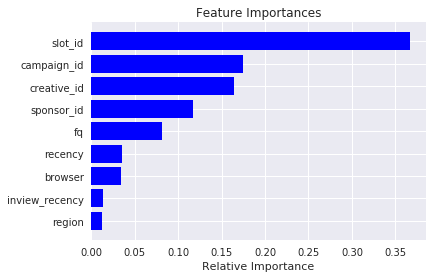

In [30]:
importances = clf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feature_cols[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


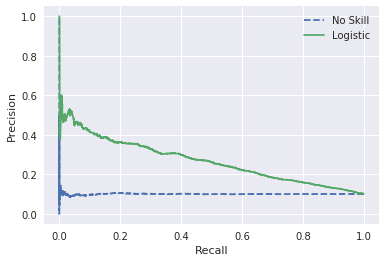

AUC(PR):0.2677795647257137


In [31]:
# precision-recall curve and f1
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from matplotlib import pyplot
import random
# generate a no skill prediction (majority class)
no_skill_probs = [i for i in np.random.rand(len(test_y))]
# calculate precision and recall for each threshold
ns_precision, ns_recall, _ = precision_recall_curve(test_y, no_skill_probs)
lr_precision, lr_recall, _ = precision_recall_curve(test_y, y_pred)

# plot the precision-recall curves
pyplot.plot(ns_recall, ns_precision, linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, linestyle='-', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
print("AUC(PR):%s" %str(auc(lr_recall, lr_precision)))

# With features made by me

In [27]:
# featureとラベルをそれぞれ抽出してtrain/testに分割
feature_cols =  ['browser',
       'slot_id', 'campaign_id', 'creative_id',
       'region', 'fq', 'recency', 'inview_recency', 'request_hour']
label_col = "click_flg"
features = df_final[feature_cols]
labels = df_final[label_col]
train_x = features.iloc[0:int(num_data*0.8),:]
val_x = features.iloc[int(num_data*0.8):int(num_data*0.9),:]
test_x = features.iloc[int(num_data*0.9):num_data,:]
train_y = labels[0:int(num_data*0.8)]
val_y = labels[int(num_data*0.8):int(num_data*0.9)]
test_y = labels[int(num_data*0.9):num_data]

In [28]:
class TargetEncoding_ws(object):
    """
    DFと変換したいカラムリスト、targetを引数として、Target Encoding with Smoothingを行う
    引数
    dataframe : DF全体 (pd.DataFrame)
    target : 目的変数のカラム (np.ndarray or np.Series)
    list_cols : 変換したいカラムリスト (list[str])
    k : smoothingのハイパーパラメータ (int)
    impute : 未知のカテゴリに平均を入れるか (boolean)
    """
    def __init__(self, list_cols, k=100, impute=True):
        self.df = None
        self.target = None
        self.list_cols = list_cols
        self.k = k
        self.impute = impute
        self.target_map = {}
        self.target_mean = None

    def sigmoid(self, x, k):
        return 1 / (1 + np.exp(- x / k))

    def fit_univariate(self, target, col):
        """
        一つの変数に対するTarget_Encoding
        col : TargetEncodingしたい変数名
        """
        df = self.df.copy()
        k = self.k
        df["target"] = target
        n_i = df.groupby(col).count()["target"]

        lambda_n_i = self.sigmoid(n_i, k)
        uni_map = df.groupby(col).mean()["target"]

        return lambda_n_i * df.loc[:, "target"].mean() + (1 - lambda_n_i) * uni_map

    def fit(self, data, target):
        """
        複数カラムにも対応したTargetEncoding
        """
        self.df = data.copy()
        self.target = target

        if self.impute == True:
            self.target_mean = target.mean()

        #各カラムのmapを保存
        for col in list_cols:
            self.target_map[col] = self.fit_univariate(target, col)

    def transform(self, x):
        list_cols = self.list_cols
        x_d = x.copy()
        for col in list_cols:
            x_d.loc[:, col] = x_d.loc[:, col].map(self.target_map[col])

            #impute
            if self.impute == True:
                x_d.loc[:, col] = np.where(x_d.loc[:, col].isnull(), self.target_mean, x_d.loc[:, col])

        return x_d

In [29]:
list_cols = ['browser',
       'slot_id', 'campaign_id', 'creative_id',
       'region', 'request_hour']

In [30]:
te = TargetEncoding_ws(list_cols=list_cols, k=300, impute=True)
te.fit(train_x, train_y)
train_x_1 = te.transform(train_x)
test_x_1 = te.transform(test_x)

In [31]:
clf = RandomForestClassifier(n_estimators = 300, max_depth = 40, min_samples_split = 20, max_leaf_nodes = 80)
clf.fit(train_x_1, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=40, max_features='auto', max_leaf_nodes=80,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [32]:
# 評価指標としてrocaucを計算する
y_pred = clf.predict_proba(test_x_1)[:, 1]
print("AUC(ROC):{}".format(roc_auc_score(test_y,y_pred)))

AUC(ROC):0.7646213655236962


In [33]:
from sklearn.metrics import roc_curve, auc
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

# Find optimal probability threshold
threshold = Find_Optimal_Cutoff(test_y, y_pred)
print (threshold)
# [0.31762762459360921]

# Find prediction to the dataframe applying threshold
pred = []
for i in y_pred:
  if i>threshold:
    pred.append(1)
  else:
    pred.append(0)

# Print confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(test_y, pred)
# array([[175,  98],
#        [ 46,  81]])

[0.09493895792818476]


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:18: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


array([[12725,  5264],
       [  590,  1421]])

In [14]:
sorted(list(zip(feature_cols, clf.feature_importances_)), key=lambda x: x[1], reverse=True)

[('slot_id', 0.7029863216067949),
 ('creative_id', 0.17347579090689227),
 ('fq', 0.045229206227198095),
 ('campaign_id', 0.028873850709643538),
 ('recency', 0.02377198907900657),
 ('region', 0.010693094016089916),
 ('inview_recency', 0.009798148213747502),
 ('request_hour', 0.004525780351044682),
 ('browser', 0.0006458188895825417)]

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


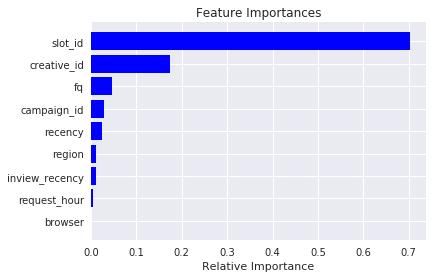

In [15]:
importances = clf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feature_cols[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


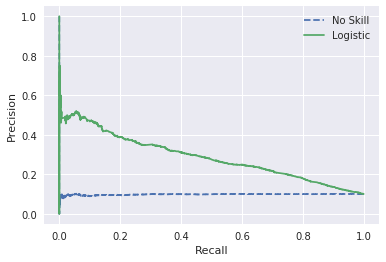

In [16]:
# precision-recall curve and f1
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from matplotlib import pyplot
import random
# generate a no skill prediction (majority class)
no_skill_probs = [i for i in np.random.rand(len(test_y))]
# calculate precision and recall for each threshold
ns_precision, ns_recall, _ = precision_recall_curve(test_y, no_skill_probs)
lr_precision, lr_recall, _ = precision_recall_curve(test_y, y_pred)

# plot the precision-recall curves
pyplot.plot(ns_recall, ns_precision, linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, linestyle='-', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [17]:
from sklearn.metrics import auc
print("AUC(PR):%s" %str(auc(lr_recall, lr_precision)))

AUC(PR):0.2879448583297637


In [34]:
y_pred_str = [str(n) for n in y_pred]

In [35]:
with open('randomforest_1.txt', 'w') as rd:
    rd.writelines('\n'.join(y_pred_str))

In [21]:
with open('randomforest.txt', 'r') as rd:
    y_pred = [float(s.strip()) for s in rd.readlines()]

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
def objective(trial):
  params = {
            'n_estimators': int(trial.suggest_loguniform('n_estimators', 1e+2, 1e+3)),
            'max_depth': int(trial.suggest_loguniform('max_depth', 2, 32)),
            'min_samples_split':trial.suggest_int("min_samples_split", 8, 16),
            'max_leaf_nodes':int(trial.suggest_discrete_uniform("max_leaf_nodes", 4, 64, 4))
        }
    
  RFC = RandomForestClassifier(**params)
  RFC.fit(train_x, train_y)
  y_pred = clf.predict_proba(test_x)[:, 1]
  return 1.0 - roc_auc_score(test_y, y_pred)